## ExMAS
> Equilibrium matching


In [1]:
import os
import math
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
cwd = os.getcwd()
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display
pd.options.display.max_columns = None

In [3]:
os.chdir(os.path.join(cwd,'../../..'))
import ExMAS.main
import ExMAS.utils
from ExMAS.utils import inData as inData
from ExMAS.main import matching
from ExMAS.extras import games, pricings, prunings, pipeline

In [20]:
params = ExMAS.utils.get_config('ExMAS/spinoffs/game/pipe.json') # load the default 
params.t0 = pd.to_datetime(params.t0)
params.matching_obj = 'u_pax'
inData = ExMAS.utils.load_G(inData, params, stats=True)  # download the graph
params.nP = 150
params.simTime = 0.2
params.shared_discount = 0.3
inData = ExMAS.utils.generate_demand(inData, params)  # generate requests

In [21]:
from ExMAS.main import init_log
params.logger_level = 'WARNING'
inData.logger = init_log(params)

In [22]:
inData = ExMAS.main(inData, params, plot = False)
KPIs = inData.sblts.res.to_frame('u_pax')
inData = games.prepare_PoA(inData)  # prepare data structures

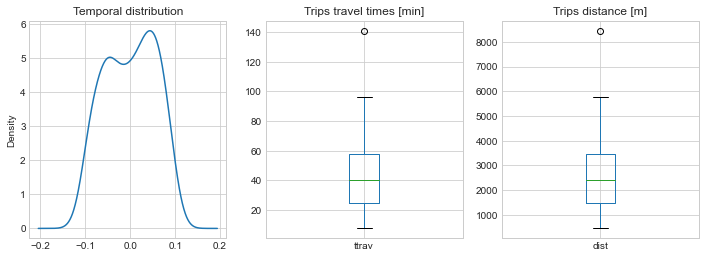

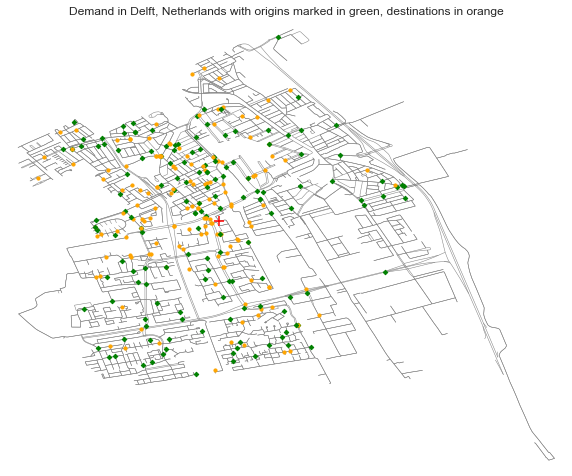

In [23]:
ExMAS.utils.plot_demand(inData, params)

### incidence matrix
rows are trips columns are rides,
1 if trip blongs to a ride, 0 otherwise

### parameters

eq. 1 , eq.2

In [9]:

params.time_cost = params.VoT # travellers' cost per travel time
params.wait_cost = params.time_cost*1.5 # and waiting
params.sharing_penalty_fixed = 0 # fixed penalty (EUR) per 
params.sharing_penalty_multiplier = 0.2 # fixed penalty (EUR) per 

params.veh_cost = 1.3*params.VoT/params.avg_speed # operating costs per kilometer
params.fixed_ride_cost = 0.5 # ride fixed costs (per vehicle)

In [10]:
inData = games.prepare_PoA(inData)

### pricings with various strategies

ride  traveller  shared  degree  treq ride_time  dist  ttrav  \
57  8     57          8    True       2    53       626  2652    331   
    15    57         15    True       2   125       626  2124    265   
92  19    92         19    True       2   147       622  2423    302   
    31    92         31    True       2   237       622  2936    367   
109 18   109         18    True       2   142       475  2018    252   
    46   109         46    True       2   346       475  2313    289   
182 42   182         42    True       2   305       408  2836    354   
    35   182         35    True       2   257       408  2346    293   

        ttrav_sh  delay distance cost_veh  cost_user  total_group_cost  \
57  8        346 -129.5     5008   3.3483   2.133075           7.35300   
    15       265  144.5     5008   3.3483   1.871625           7.35300   
92  19       352  -30.0     4976   3.3301   1.635900           7.05865   
    31       442   45.0     4976   3.3301   2.092650           7.05865   
109 18       276   34.5     3800  2.66125   1.340325           5.40595   
    46       310  -19.5     3800  2.66125   1.404375           5.40595   
182 42       393  -53.0     3264   2.3564   1.928850           5.98625   
    35       320   68.0     3264   2.3564   1.701000           5.98625   

        cost_single  total_singles  residual_user   UNIFORM  EXTERNALITY  \
57  8       3.16455        5.79780         1.5552  3.676500      4.71975   
    15      2.63325        5.79780         1.5552  3.676500      4.18845   
92  19      2.93110        6.38545         0.6732  3.529325      3.60430   
    31      3.45435        6.38545         0.6732  3.529325      4.12755   
109 18      2.52860        5.35505         0.0509  2.702975      2.57950   
    46      2.82645        5.35505         0.0509  2.702975      2.87735   
182 42      3.34970        6.20835        -0.2221  2.993125      3.12760   
    35      2.85865        6.20835        -0.2221  2.993125      2.63655   

        RESIDUAL  SUBGROUP  
57  8   0.828366   3.16455  
    15  0.726834   2.63325  
92  19  0.295366   2.93110  
    31  0.377834   3.45435  
109 18  0.024856   2.52860  
    46  0.026044   2.82645  
182 42 -0.118021   3.34970  
    35 -0.104079   2.85865

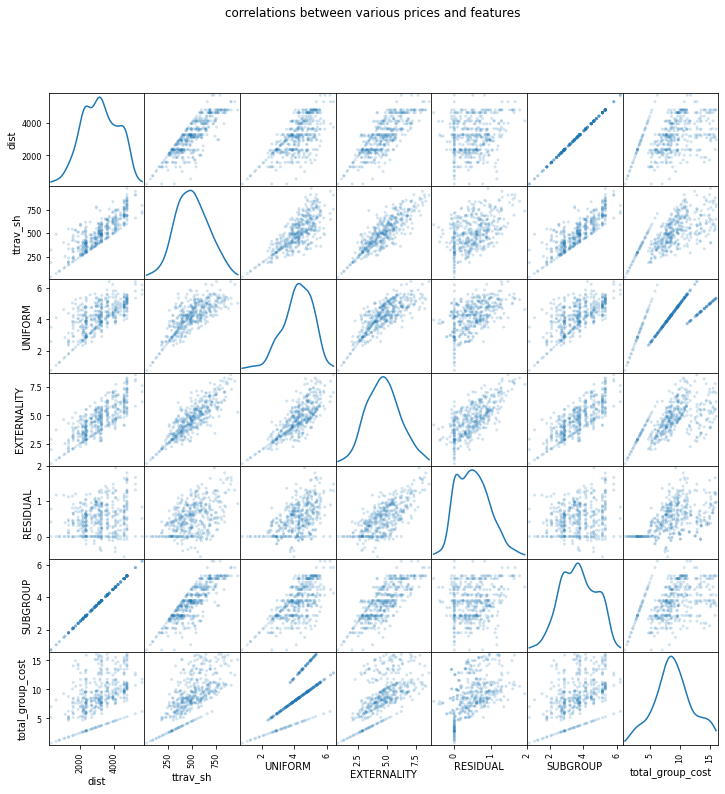

In [11]:
inData = ExMAS.extras.pricings.update_costs(inData, params)
inData = pricings.uniform_split(inData) 
inData = pricings.externality_split(inData) 
inData = pricings.residual_split(inData) 
inData = pricings.subgroup_split_bas(inData) 
rs = inData.sblts.rides.sample(4).index
plt.rcParams['figure.figsize'] = [12,12]
fig, ax = plt.subplots()
scatter_matrix(inData.sblts.rides_multi_index[['dist', 'ttrav_sh', 'UNIFORM','EXTERNALITY','RESIDUAL','SUBGROUP', 'total_group_cost']], grid = False, diagonal = 'kde', alpha = 0.2, ax = ax)
fig.suptitle('correlations between various prices and features')
inData.sblts.rides_multi_index.loc[rs,:]

# Differences between algorithms and pricings

## TNE

In [12]:
ret = dict()
params.logger_level = 'INFO'
inData.logger = init_log(params)
for PRICING in ['UNIFORM','EXTERNALITY','RESIDUAL','SUBGROUP']:
    inData = pipeline.single_eval(inData, params, prunings.algo_TNE, PRICING = PRICING, ALGO = 'TNE', minmax = ['min'], store_res = False)
    inData.sblts.res['costs_veh'] = inData.sblts.rides[inData.sblts.rides.selected==1]['costs_veh'].sum()
    inData.sblts.res['obj'] = inData.sblts.rides[inData.sblts.rides.selected==1][PRICING].sum()
    inData.sblts.res['costs_user'] = inData.sblts.rides[inData.sblts.rides.selected==1][ 'costs_user'].sum()
    inData.sblts.res['pruned'] = inData.sblts.rides[inData.sblts.rides.selected==1].shape[0]
    ret[PRICING] = inData.sblts.res.loc[['VehHourTrav','PassHourTrav','shared_ratio','costs_veh', 'costs_user','pruned', 'obj']]
pd.DataFrame(ret).T

15-12-20 16:21:10-WARNING-Pruned nRides 51/222
15-12-20 16:21:10-WARNING-UNIFORM-TNE-UNIFORM-min
15-12-20 16:21:11-INFO-Matching 50 trips to 222 rides in order to min UNIFORM
15-12-20 16:21:11-INFO-Problem solution: Optimal. 
Total costs for single trips:            162 
reduced by matching to:                  159
15-12-20 16:21:11-INFO-DotMap(VehHourTrav=15108, VehHourTrav_ns=17058, PassHourTrav=17711, PassHourTrav_ns=17058, PassUtility=253.51685, PassUtility_ns=264.633, mean_lambda=0.30019524894240157, revenue_s=17910.899999999998, revenue_ns=25587.0, Fare_Discount=-0.3000000000000001, nR=50, SINGLE=36, PAIRS=7, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.28, fleet_size_nonshared=45.0, fleet_size_shared=38.0, lambda_shared=0.30019524894240157)
15-12-20 16:21:11-WARNING-Pruned nRides 61/222
15-12-20 16:21:11-WARNING-EXTERNALITY-TNE-EXTERNALITY-min
15-12-20 16:21:12-INFO-Matching 50 trips to 222 rides in order to min EXTERNALITY
15-12-20 16:21:12-INFO-Problem solution

,VehHourTrav,PassHourTrav,shared_ratio,costs_veh,costs_user,pruned,obj
UNIFORM,15108,17711,0.28,90.7192,68.9161,43,159.635
EXTERNALITY,15108,17711,0.28,90.7192,68.9161,43,159.635
RESIDUAL,15108,17711,0.28,90.7192,68.9161,43,-2.6817
SUBGROUP,15815,19702,0.76,88.755,100.877,31,162.314


## Hermetic

In [13]:
ret = dict()
params.logger_level = 'WARNING'
inData.logger = init_log(params)
for PRICING in ['UNIFORM','EXTERNALITY','RESIDUAL','SUBGROUP']:
    inData = pipeline.single_eval(inData, params, prunings.algo_HERMETIC, PRICING = PRICING, ALGO = 'HERMETIC', minmax = ['min'], store_res = False)
    inData.sblts.res['costs_veh'] = inData.sblts.rides[inData.sblts.rides.selected==1]['costs_veh'].sum()
    inData.sblts.res['obj'] = inData.sblts.rides[inData.sblts.rides.selected==1][PRICING].sum()
    inData.sblts.res['costs_user'] = inData.sblts.rides[inData.sblts.rides.selected==1][ 'costs_user'].sum()
    inData.sblts.res['pruned'] = inData.sblts.rides[inData.sblts.rides.selected==1].shape[0]
    ret[PRICING] = inData.sblts.res.loc[['VehHourTrav','PassHourTrav','shared_ratio','costs_veh', 'costs_user','pruned', 'obj']]
pd.DataFrame(ret).T

15-12-20 16:21:15-WARNING-Pruned nRides 51/222
15-12-20 16:21:15-WARNING-UNIFORM-HERMETIC-UNIFORM-min
15-12-20 16:21:16-WARNING-Pruned nRides 58/222
15-12-20 16:21:16-WARNING-EXTERNALITY-HERMETIC-EXTERNALITY-min
15-12-20 16:21:17-WARNING-Pruned nRides 58/222
15-12-20 16:21:17-WARNING-RESIDUAL-HERMETIC-RESIDUAL-min
15-12-20 16:21:20-WARNING-Pruned nRides 222/222
15-12-20 16:21:20-WARNING-SUBGROUP-HERMETIC-SUBGROUP-min


,VehHourTrav,PassHourTrav,shared_ratio,costs_veh,costs_user,pruned,obj
UNIFORM,15108,17711,0.28,90.7192,68.9161,43,159.635
EXTERNALITY,15108,17711,0.28,90.7192,68.9161,43,159.635
RESIDUAL,15108,17711,0.28,90.7192,68.9161,43,-2.6817
SUBGROUP,15815,19702,0.76,88.755,100.877,31,162.314


## RUE

In [14]:
ret = dict()
params.logger_level = 'INFO'
inData.logger = init_log(params)
for PRICING in ['UNIFORM','EXTERNALITY','RESIDUAL','SUBGROUP']:
    inData = pipeline.single_eval(inData, params, prunings.algo_RUE, PRICING = PRICING, ALGO = 'RUE', minmax = ['min'], store_res = False)
    inData.sblts.res['costs_veh'] = inData.sblts.rides[inData.sblts.rides.selected==1]['costs_veh'].sum()
    inData.sblts.res['obj'] = inData.sblts.rides[inData.sblts.rides.selected==1][PRICING].sum()
    inData.sblts.res['costs_user'] = inData.sblts.rides[inData.sblts.rides.selected==1][ 'costs_user'].sum()
    inData.sblts.res['pruned'] = inData.sblts.rides[inData.sblts.rides.selected==1].shape[0]
    ret[PRICING] = inData.sblts.res.loc[['VehHourTrav','PassHourTrav','shared_ratio','costs_veh', 'costs_user','pruned', 'obj']]
pd.DataFrame(ret).T

15-12-20 16:21:21-INFO-Mergeable groups: 25-30
15-12-20 16:21:22-INFO-Mergeable groups: 5-88
15-12-20 16:21:22-INFO-Mergeable groups: 47-148
15-12-20 16:21:22-WARNING-Pruned nRides 222/222
15-12-20 16:21:22-WARNING-UNIFORM-RUE-UNIFORM-min
15-12-20 16:21:22-INFO-Matching 50 trips to 222 rides in order to min UNIFORM
15-12-20 16:21:22-INFO-Adding 3 mutually exlcusive constrains
15-12-20 16:21:22-INFO-Problem solution: Optimal. 
Total costs for single trips:            162 
reduced by matching to:                  159
15-12-20 16:21:22-INFO-DotMap(VehHourTrav=15108, VehHourTrav_ns=17058, PassHourTrav=17711, PassHourTrav_ns=17058, PassUtility=253.51685, PassUtility_ns=264.633, mean_lambda=0.30019524894240157, revenue_s=17910.899999999998, revenue_ns=25587.0, Fare_Discount=-0.3000000000000001, nR=50, SINGLE=36, PAIRS=7, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.28, fleet_size_nonshared=45.0, fleet_size_shared=38.0, lambda_shared=0.30019524894240157)
15-12-20 16:21:22-INFO

,VehHourTrav,PassHourTrav,shared_ratio,costs_veh,costs_user,pruned,obj
UNIFORM,15108,17711,0.28,90.7192,68.9161,43,159.635
EXTERNALITY,15108,17711,0.28,90.7192,68.9161,43,159.635
RESIDUAL,15108,17711,0.28,90.7192,68.9161,43,-2.6817
SUBGROUP,15815,19702,0.76,88.755,100.877,31,162.314


## RSIE

In [15]:
ret = dict()
params.logger_level = 'INFO'
inData.logger = init_log(params)
for PRICING in ['UNIFORM','EXTERNALITY','RESIDUAL','SUBGROUP']:
    inData = pipeline.single_eval(inData, params, prunings.algo_RSIE, PRICING = PRICING, ALGO = 'RSIE', minmax = ['min'], store_res = False)
    inData.sblts.res['costs_veh'] = inData.sblts.rides[inData.sblts.rides.selected==1]['costs_veh'].sum()
    inData.sblts.res['obj'] = inData.sblts.rides[inData.sblts.rides.selected==1][PRICING].sum()
    inData.sblts.res['costs_user'] = inData.sblts.rides[inData.sblts.rides.selected==1][ 'costs_user'].sum()
    inData.sblts.res['pruned'] = inData.sblts.rides[inData.sblts.rides.selected==1].shape[0]
    ret[PRICING] = inData.sblts.res.loc[['VehHourTrav','PassHourTrav','shared_ratio','costs_veh', 'costs_user','pruned', 'obj']]
pd.DataFrame(ret).T

15-12-20 16:21:27-WARNING-Searching unstable pairs 0/222. 0 found so far
15-12-20 16:21:36-WARNING-Searching unstable pairs 20/222. 96 found so far
15-12-20 16:21:44-WARNING-Searching unstable pairs 40/222. 157 found so far
15-12-20 16:21:51-WARNING-Searching unstable pairs 60/222. 186 found so far
15-12-20 16:21:56-WARNING-Searching unstable pairs 80/222. 193 found so far
15-12-20 16:22:01-WARNING-Searching unstable pairs 100/222. 205 found so far
15-12-20 16:22:06-WARNING-Searching unstable pairs 120/222. 205 found so far
15-12-20 16:22:10-WARNING-Searching unstable pairs 140/222. 210 found so far
15-12-20 16:22:15-WARNING-Searching unstable pairs 160/222. 239 found so far
15-12-20 16:22:19-WARNING-Searching unstable pairs 180/222. 239 found so far
15-12-20 16:22:24-WARNING-Searching unstable pairs 200/222. 240 found so far
15-12-20 16:22:28-WARNING-Searching unstable pairs 220/222. 240 found so far
15-12-20 16:22:28-WARNING-Pruned nRides 222/222
15-12-20 16:22:28-WARNING-UNIFORM-RSI

,VehHourTrav,PassHourTrav,shared_ratio,costs_veh,costs_user,pruned,obj
UNIFORM,15108,17711,0.28,90.7192,68.9161,43,159.635
EXTERNALITY,15108,17711,0.28,90.7192,68.9161,43,159.635
RESIDUAL,15108,17711,0.28,90.7192,68.9161,43,-2.6817
SUBGROUP,15197,19623,0.8,85.5113,95.9004,30,162.314


## TSE

In [16]:
ret = dict()
params.logger_level = 'INFO'
inData.logger = init_log(params)
for PRICING in ['UNIFORM','EXTERNALITY','RESIDUAL','SUBGROUP']:
    inData = pipeline.single_eval(inData, params, prunings.algo_TSE, PRICING = PRICING, ALGO = 'TSE', minmax = ['min'], store_res = False)
    inData.sblts.res['costs_veh'] = inData.sblts.rides[inData.sblts.rides.selected==1]['costs_veh'].sum()
    inData.sblts.res['obj'] = inData.sblts.rides[inData.sblts.rides.selected==1][PRICING].sum()
    inData.sblts.res['costs_user'] = inData.sblts.rides[inData.sblts.rides.selected==1][ 'costs_user'].sum()
    inData.sblts.res['pruned'] = inData.sblts.rides[inData.sblts.rides.selected==1].shape[0]
    ret[PRICING] = inData.sblts.res.loc[['VehHourTrav','PassHourTrav','shared_ratio','costs_veh', 'costs_user','pruned', 'obj']]
pd.DataFrame(ret).T

15-12-20 16:25:26-WARNING-Pruned nRides 222/222
15-12-20 16:25:26-INFO-DotMap(VehHourTrav=16748, VehHourTrav_ns=17058, PassHourTrav=19623, PassHourTrav_ns=17058, PassUtility=248.87515, PassUtility_ns=264.633, mean_lambda=0.30825496342737724, revenue_s=17910.899999999998, revenue_ns=25587.0, Fare_Discount=-0.3000000000000001, nR=50, SINGLE=48, PAIRS=1, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.040000000000000036, fleet_size_nonshared=45.0, fleet_size_shared=44.0, lambda_shared=0.953082919914954)
15-12-20 16:25:26-WARNING-Pruned nRides 222/222
15-12-20 16:25:26-INFO-DotMap(VehHourTrav=16748, VehHourTrav_ns=17058, PassHourTrav=19623, PassHourTrav_ns=17058, PassUtility=248.87515, PassUtility_ns=264.633, mean_lambda=0.30825496342737724, revenue_s=17910.899999999998, revenue_ns=25587.0, Fare_Discount=-0.3000000000000001, nR=50, SINGLE=48, PAIRS=1, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.040000000000000036, fleet_size_nonshared=45.0, fleet_size_shared=4

,VehHourTrav,PassHourTrav,shared_ratio,costs_veh,costs_user,pruned,obj
UNIFORM,16748,19623,0.04,100.772,61.3221,49,162.094
EXTERNALITY,16748,19623,0.04,100.772,61.3221,49,162.094
RESIDUAL,15108,19623,0.28,90.7192,68.9161,43,-2.6817
SUBGROUP,17058,19623,0,102.614,59.703,50,162.314


---
(c) Rafał Kucharski, Delft, 2020